# Measure a Profile for Different Centerings

_the LSST-DESC CLMM team_

This notebook demonstrates how to use `CLMM` to measure a profile and how to estimate a WL halo mass from observations of a galaxy cluster for different misscenterings. It uses several functionalities of the support mock_data module to produce datasets of increasing complexity. In this notebook, we do the following:

-Setting things up, with the proper imports. 

-Generating several datasets for the same cosmology but different misscenterings.

-Computing the binned reduced tangential shear profile, for all the datasets, using logarithmic binning.

-Plotting the tangential and the cross shears versus the radius to analyze the impact of misscentering.

-Fitting the data to a halo mass model and analyzing the impact in the weak lensing mass.

## Note

All functions in this section can be used passing the explicit arguments but are also internal functions of the cluster object, and should be used as such. They are just explicitely used here for clarity.

Ex:

```
theta, g_t, g_x = compute_tangential_and_cross_components(ra_lens, dec_lens,
                ra_source, dec_source, shear1, shear2, geometry="flat")
```

should be done by the user as:

```
theta, g_t, g_x = cl.compute_tangential_and_cross_components(geometry="flat")
```

In [1]:
import matplotlib.pyplot as plt
import clmm
import clmm.dataops
from clmm.dataops import compute_tangential_and_cross_components, make_radial_profile, make_bins
from clmm.galaxycluster import GalaxyCluster
import clmm.utils as u
from clmm import Cosmology
from clmm.support import mock_data as mock
import clmm.galaxycluster as gc
from numpy import random 
import numpy as np
import clmm.dataops as da


Make sure we know which version we're using

In [2]:
clmm.__version__

'1.0.1'

### Define cosmology object

In [3]:
mock_cosmo = Cosmology(H0 = 70.0, Omega_dm0 = 0.27 - 0.045, Omega_b0 = 0.045, Omega_k0 = 0.0)
np.random.seed(11)

## 1. Generate cluster object from mock data
In this example, the mock data includes: shape noise, galaxies drawn from redshift distribution and photoz errors.

Define toy cluster parameters for mock data generation

In [4]:
cosmo = mock_cosmo
cluster_id = "Awesome_cluster"
cluster_m = 1.e15
cluster_z = 0.3
concentration = 4
ngals = 1000

zsrc_min = cluster_z + 0.1 # we only want to draw background galaxies

noisy_data_z = mock.generate_galaxy_catalog(cluster_m,
                                            cluster_z,
                                            concentration,
                                            cosmo,
                                            'chang13',
                                            zsrc_min=zsrc_min,
                                            shapenoise=0.005,
                                            photoz_sigma_unscaled=0.05, ngals=ngals)

Loading this into several CLMM cluster objects centered between (-0.2, -0.2) - (0.2, 0.2). The user can change the number of misscenterings if desired. Currently, the example is running for 10 different centers. After generating the CLMM cluster objects, we save them into mock data.

In [5]:
center_number = 10
for a in range (0,center_number):
    cluster_ra = random.uniform(-0.2, 0.2)
    cluster_dec =random.uniform(-0.2, 0.2)
    GalaxyCluster(cluster_id, cluster_ra, cluster_dec, 
                                  cluster_z, noisy_data_z)
    gc_object = clmm.GalaxyCluster(cluster_id, cluster_ra, cluster_dec,
                               cluster_z, noisy_data_z)
    gc_object.save(f'mock.gc{str(a)}.pkl')


### 2. Load cluster object containing:
> Lens properties (ra_l, dec_l, z_l)

> Source properties (ra_s, dec_s, e1, e2)
### Note, if loading from mock data, use: 
> cl = gc.GalaxyCluster.load("GC_from_mock_data.pkl")

We need to load the data for all the different centerings and save it in a list.

In [6]:
cluster_list = []
for a in range (0,center_number):
    cl = gc.GalaxyCluster.load(f"mock.gc{str(a)}.pkl")
    print("Cluster info = ID:", cl.unique_id, "; ra:", cl.ra,
          "; dec:", cl.dec, "; z_l :", cl.z)
    print("The number of source galaxies is :", len(cl.galcat))
    cluster_list.append(cl)

Cluster info = ID: Awesome_cluster ; ra: 0.007249214019981298 ; dec: -0.011737669051895105 ; z_l : 0.3
The number of source galaxies is : 1000
Cluster info = ID: Awesome_cluster ; ra: -0.19285467195125136 ; dec: -0.15877486431683244 ; z_l : 0.3
The number of source galaxies is : 1000
Cluster info = ID: Awesome_cluster ; ra: -0.09449129129254215 ; dec: -0.021787572982089914 ; z_l : 0.3
The number of source galaxies is : 1000
Cluster info = ID: Awesome_cluster ; ra: 0.04864946644895221 ; dec: -0.0025022564508458967 ; z_l : 0.3
The number of source galaxies is : 1000
Cluster info = ID: Awesome_cluster ; ra: 0.19271122337689828 ; dec: -0.17632131729489428 ; z_l : 0.3
The number of source galaxies is : 1000
Cluster info = ID: Awesome_cluster ; ra: 0.044318965769657354 ; dec: 0.04870476098161941 ; z_l : 0.3
The number of source galaxies is : 1000
Cluster info = ID: Awesome_cluster ; ra: 0.07405479591495756 ; dec: -0.029627095580103097 ; z_l : 0.3
The number of source galaxies is : 1000
Clust

## 2. Basic checks and plots 
- galaxy positions
- redshift distribution

For a better visualization, we plot all the different centers in the Cluster, represented by the red dots.

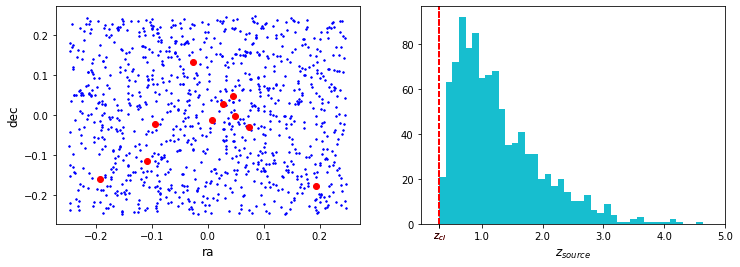

In [7]:
f, ax = plt.subplots(1, 2, figsize=(12, 4))
for cl in cluster_list:
    ax[0].scatter(cl.galcat['ra'], cl.galcat['dec'], color='blue', s=1, alpha=0.3)
    ax[0].plot(cl.ra, cl.dec, 'ro')
    ax[0].set_ylabel('dec', fontsize="large")
    ax[0].set_xlabel('ra', fontsize="large")

    hist = ax[1].hist(cl.galcat['z'], bins=40)[0]

    ax[1].axvline(cl.z, c='r', ls='--')
    ax[1].set_xlabel('$z_{source}$', fontsize="large")
    xt = {t:f'{t}' for t in ax[1].get_xticks() if t!=0}
    xt[cl.z] ='$z_{cl}$'
    xto = sorted(list(xt.keys())+[cl.z])
    ax[1].set_xticks(xto)
    ax[1].set_xticklabels(xt[t] for t in xto)
    ax[1].get_xticklabels()[xto.index(cl.z)].set_color('red')
    plt.xlim(0, max(xto))
plt.show()

## 3. Compute and plot shear profiles

Next, we generate the profiles for all the Cluster objects and save the profiles into a list. We also save the `gt`, `gx`, and `radius` columns of each `profile` into lists, so we can make a plot of these components. 

## Note
If the user wants to observe the individual shear profile and plots for each cluster, uncomment the lines:
> cl.profile.pprint(max_width=-1)

> fig, ax = cl.plot_profiles(xscale='log')

> cl.profile.show_in_notebook()

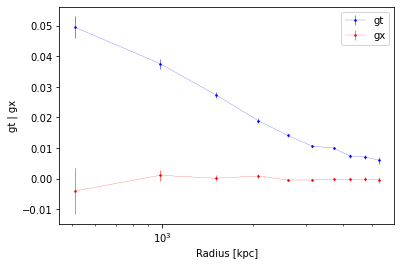

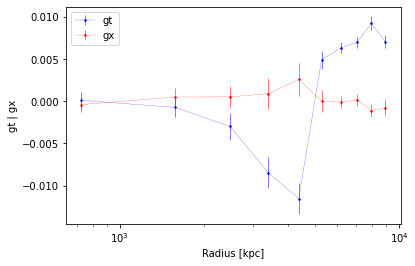

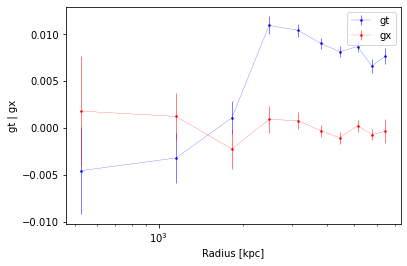

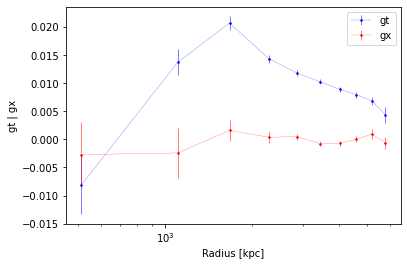

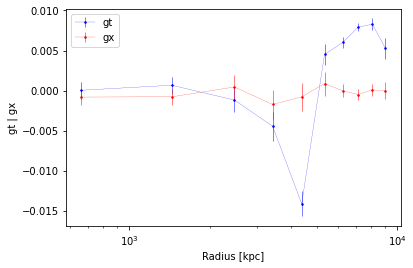

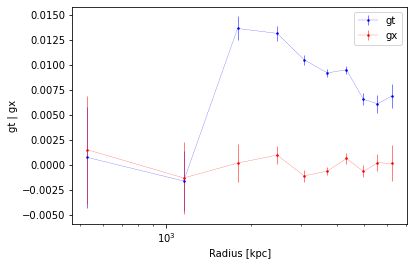

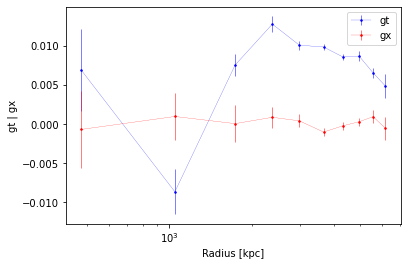

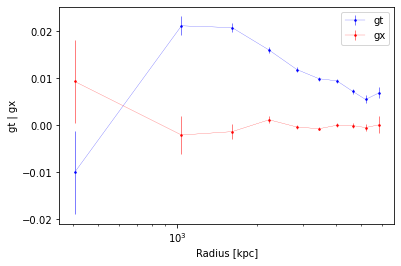

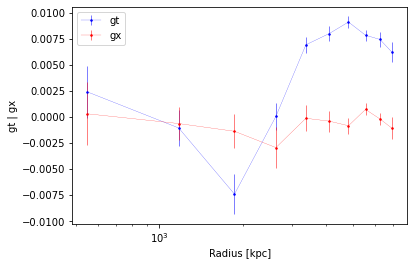

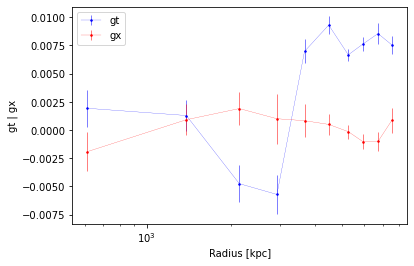

In [8]:
profile_list = []
gt_list = []
gx_list = []
radius_list = []
for cl in cluster_list:
    theta, e_t, e_x = compute_tangential_and_cross_components(
                    ra_lens=cl.ra, dec_lens=cl.dec,
                    ra_source=cl.galcat['ra'], dec_source=cl.galcat['dec'],
                    shear1=cl.galcat['e1'], shear2=cl.galcat['e2'],
                    geometry="flat")
    cl.compute_tangential_and_cross_components(geometry="flat", add=True)
    cl.make_radial_profile("kpc", cosmo=cosmo)
    profile_list.append(cl.profile)
    #cl.profile.pprint(max_width=-1)
    fig, ax = cl.plot_profiles(xscale='log')

for b in profile_list:
    gt_list.append(b['gt'].pformat())
    gx_list.append(b['gx'].pformat())
    radius_list.append(b['radius'].pformat())
#cl.profile.show_in_notebook()

Before we plot the tangential and cross components, we need to transform the columns into floats since the `pformat` method returns the columns as strings. Then we can plot the two graphs below.

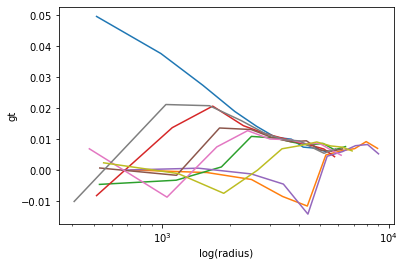

In [9]:

for b in range(len(profile_list)-1):
    plt.xscale('log')
    radius_list[b][2:] = [float(a) for a in radius_list[b][2:]]
    gt_list[b][2:] = [float(a) for a in gt_list[b][2:]]
    gx_list[b][2:] = [float(a) for a in gx_list[b][2:]]
    plt.plot(radius_list[b][2:], gt_list[b][2:], label=f'centering {b}')
plt.xlabel('log(radius)')
plt.ylabel('gt')
plt.show()
#plt.legend(loc="upper left")



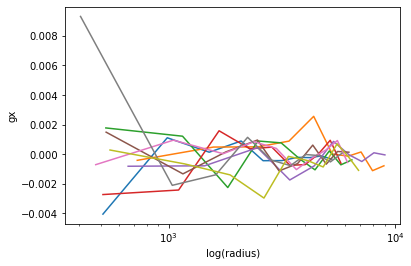

In [10]:
for b in range(len(profile_list)-1):
    plt.xscale('log')
    plt.plot(radius_list[b][2:], gx_list[b][2:])

plt.xlabel('log(radius)')
plt.ylabel('gx')
plt.show()

## 4. Compute the fitting Halo mass and Plot

In this last step, we compute the fitting Halo mass with the `nfw` model and, using a plot, compare the impact of the Cluster misscenterings on the weak lensing mass.

In [11]:
from clmm.support.sampler import samplers


The function below defines the Halo model.

In [12]:
logm_0 = random.uniform(13., 17., 1)[0]
def nfw_to_shear_profile(logm, profile_info):
    [r, gt_profile, z_src_rbin] = profile_info
    m = 10.**logm
    gt_model = clmm.compute_reduced_tangential_shear(r,
                                                     m, concentration,
                                                     cluster_z, z_src_rbin, cosmo,
                                                     delta_mdef=200,
                                                     halo_profile_model='nfw')
    return np.sum((gt_model - gt_profile)**2)

The log of the mass is :34.22503103632421, for the cluster centering:(0.007249214019981298,-0.011737669051895105)
The log of the mass is :21.694558714479044, for the cluster centering:(-0.19285467195125136,-0.15877486431683244)
The log of the mass is :20.847777985497075, for the cluster centering:(-0.09449129129254215,-0.021787572982089914)
The log of the mass is :19.229553109707272, for the cluster centering:(0.04864946644895221,-0.0025022564508458967)
The log of the mass is :22.59228262796506, for the cluster centering:(0.19271122337689828,-0.17632131729489428)
The log of the mass is :29.82323161516441, for the cluster centering:(0.044318965769657354,0.04870476098161941)
The log of the mass is :30.466144312072824, for the cluster centering:(0.07405479591495756,-0.029627095580103097)
The log of the mass is :30.80289334880682, for the cluster centering:(0.02717730938207369,0.028471528314227446)
The log of the mass is :26.77998910756119, for the cluster centering:(-0.02620220169522,0.13

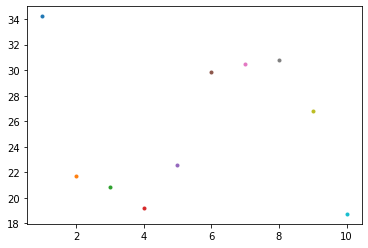

In [14]:
count = 1 #This value is just for a better visualization of the plot, so the are not in the same vertical line.
for cl in cluster_list:
    bin_edges1 = make_bins(0.01, 3.7, 50)
    theta, e_t, e_x = compute_tangential_and_cross_components(
                    ra_lens=cl.ra, dec_lens=cl.dec,
                    ra_source=cl.galcat['ra'], dec_source=cl.galcat['dec'],
                    shear1=cl.galcat['e1'], shear2=cl.galcat['e2'],
                    geometry="flat")
    z=cl.z
    z_s = cl.galcat['z']
    res1 = da.make_radial_profile(
        [e_t, e_x, z_s], theta, "radians", "Mpc", bins=bin_edges1, cosmo=cosmo, z_lens=z, include_empty_bins=False)
    gt_profile1 = res1['p_0']
    r1 = res1['radius']
    z1 = res1['p_2']
    #logm_est1 = samplers['minimize'](nfw_to_shear_profile, logm_0,args=[r1, gt_profile1, z1])[0]
    logm_est1 = samplers['basinhopping'](nfw_to_shear_profile, logm_0, minimizer_kwargs={'args': ([r1, gt_profile1, z1])})[0]
    m_est1 = 10.**logm_est1 # The user may also plot this value instead of the log.
    print(f"The log of the mass is :{np.log(m_est1)}, for the cluster centering:({cl.ra},{cl.dec})")
    plt.plot(count,np.log(m_est1), '.', label=f'({cl.ra},{cl.dec})')
    count +=1
#plt.legend(loc="upper left")
plt.show()
